In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

In [3]:
pd.set_option("precision", 3)

In [4]:
df = pd.read_csv("data/calibration-2021-03-13.csv")

# Data Cleaning

In [15]:
norm.cdf(0)

0.5

In [19]:
# Removing irrelevant columns, id, state and question
df = df[["user", "lo", "hi", "ci", "solution"]]
# z: How many std deviations away is the solution from the hi/lo inferred normal
df["z"] = np.divide(df["solution"]-df["lo"], (df["hi"]-df["lo"])*norm.ppf(.95))
# The percentaliz based on the std_deviatins
df["z-percentile"] = df["z"].apply(norm.cdf)
# log(z): How many std deviations away is the solution from the hi/lo inferred lognormal
df["logz"] = np.divide(np.log(df["solution"])-np.log(df["lo"]), (np.log(df["hi"])-np.log(df["lo"]))*norm.ppf(.95))
# log(z): How many std deviations away is the solution from the hi/lo inferred lognormal
df["logz-percentile"] = df["logz"].apply(norm.cdf)

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
df.head()

,user,lo,hi,ci,solution,z,z-perc,logz
0,user1,1800.0,2020,0.9,1987.0,0.517,0.697,0.521
1,user1,1.0,100,0.9,53.0,0.319,0.625,0.524
2,user1,0.0,600,0.9,10.0,0.010,0.504,NaN
3,user2,0.0,20,0.9,70.0,2.128,0.983,NaN
4,user3,0.0,16,0.9,70.0,2.660,0.996,NaN


In [7]:
df.logz.isna().value_counts()

False    348
True      18
Name: logz, dtype: int64

# z-score density

array([[<AxesSubplot:title={'center':'z-percentile'}>]], dtype=object)

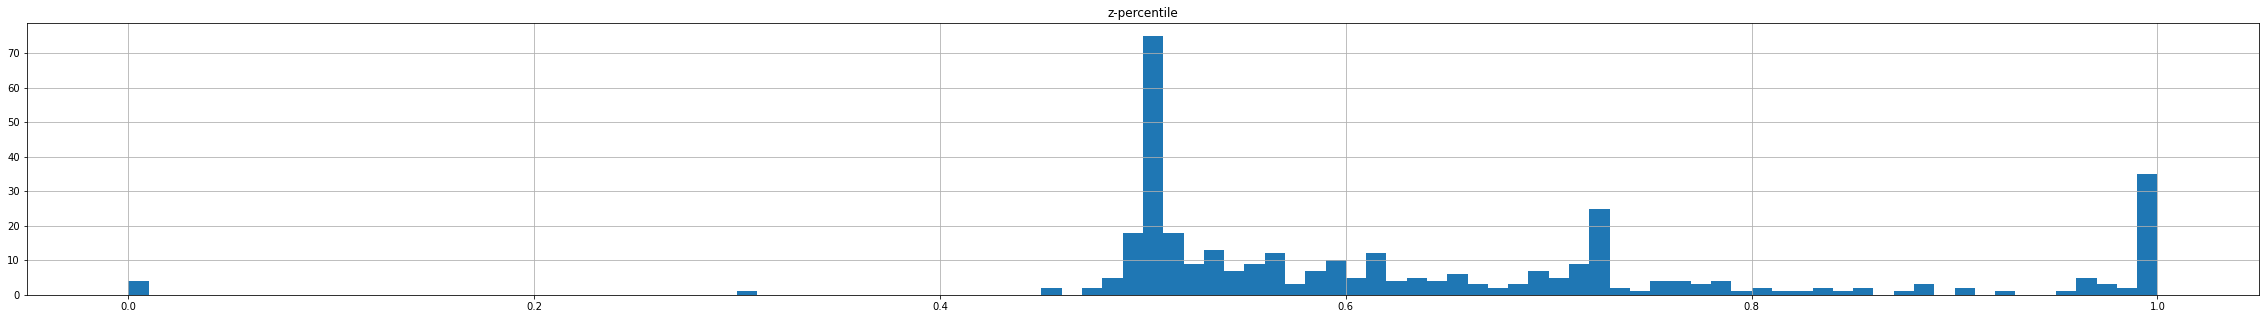

In [22]:
df.hist("z-percentile", bins=100, figsize=(40,5))

array([[<AxesSubplot:title={'center':'logz-percentile'}>]], dtype=object)

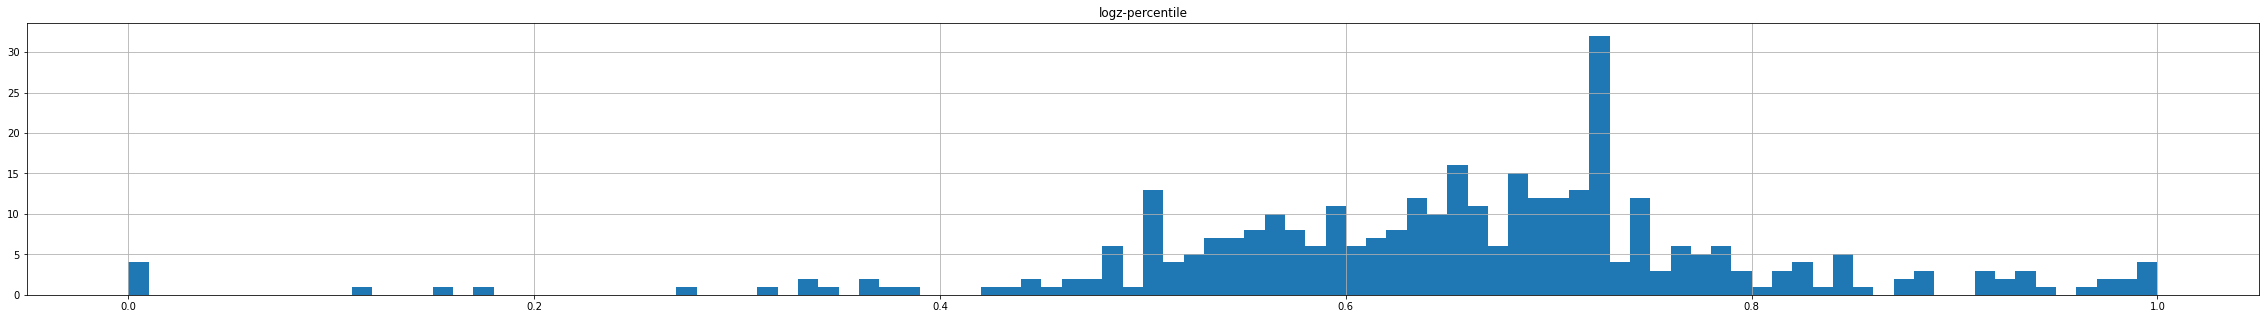

In [23]:
df.hist("logz-percentile", bins=100, figsize=(40,5))

# Auxiliary functions 

In [7]:
def get_user_table(user):
    return df[df["user"] == user][[col for col in df.columns if col != "user"]]

# Add metrics

In [8]:
n_buckets = 20
buckets = np.divide(range(1,n_buckets,1),n_buckets)
print(buckets)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


In [9]:
for ci_size in tqdm(buckets):
    alpha = np.divide(1-ci_size,2)
    df[f"ci-{ci_size}"] = df["z"].map(lambda x: x>norm.ppf(alpha) and x<norm.ppf(1-alpha))
    
for ci_size in tqdm(buckets):
    alpha = np.divide(1-ci_size,2)
    df[f"log_ci-{ci_size}"] = df["logz"].map(lambda x: x>norm.ppf(alpha) and x<norm.ppf(1-alpha))

100%|██████████| 19/19 [00:02<00:00,  8.65it/s]


In [10]:
df.head()

,user,lo,hi,ci,solution,z,logz,ci-0.05,ci-0.1,ci-0.15,...,log_ci-0.5,log_ci-0.55,log_ci-0.6,log_ci-0.65,log_ci-0.7,log_ci-0.75,log_ci-0.8,log_ci-0.85,log_ci-0.9,log_ci-0.95
0,user1,1800.0,2020,0.9,1987.0,0.517,0.521,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,user1,1.0,100,0.9,53.0,0.319,0.524,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,user1,0.0,600,0.9,10.0,0.010,NaN,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,user2,0.0,20,0.9,70.0,2.128,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,user3,0.0,16,0.9,70.0,2.660,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Calculating the buckets

In [11]:
def get_percentage(user, column):
    results = df[df["user"]==user][column].value_counts()
    return np.divide(results[True],results[True]+results[False])

In [12]:
users = df.user.unique()
df_metrics = pd.DataFrame(index = users)
for ci in buckets:
    df_metrics[ci] = df_metrics.index.map(lambda user: get_percentage(user,f"ci-{ci}"))
    
df_metrics.loc["perfect"] = buckets

In [13]:
df_metrics.T.style.background_gradient(cmap='viridis', axis=1)

,user1,user2,user3,user7,user6,user8,user5,user9,user4,user0,perfect
0.05,0.250,0.378,0.250,0.362,0.340,0.468,0.362,0.185,0.261,0.333,0.050
0.1,0.250,0.432,0.325,0.426,0.489,0.511,0.426,0.333,0.304,0.375,0.100
0.15,0.250,0.541,0.350,0.468,0.553,0.553,0.489,0.407,0.435,0.375,0.150
0.2,0.250,0.595,0.450,0.511,0.574,0.596,0.511,0.444,0.543,0.375,0.200
0.25,0.250,0.676,0.475,0.532,0.638,0.681,0.638,0.444,0.543,0.417,0.250
0.3,0.500,0.730,0.525,0.532,0.681,0.681,0.702,0.481,0.543,0.417,0.300
0.35,0.500,0.730,0.550,0.532,0.745,0.723,0.723,0.519,0.565,0.417,0.350
0.4,0.750,0.757,0.550,0.574,0.766,0.723,0.745,0.667,0.587,0.500,0.400
0.45,0.750,0.784,0.600,0.617,0.830,0.723,0.787,0.741,0.674,0.542,0.450
0.5,0.750,0.865,0.650,0.617,0.894,0.787,0.894,0.815,0.783,0.625,0.500


<AxesSubplot:>

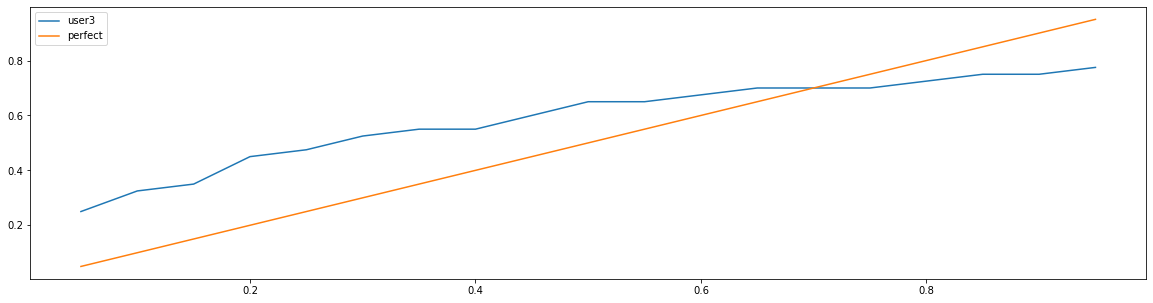

In [14]:
df_metrics.loc["user3"].plot(legend=True, figsize=(20,5))
df_metrics.loc["perfect"].plot(legend=True, figsize=(20,5))

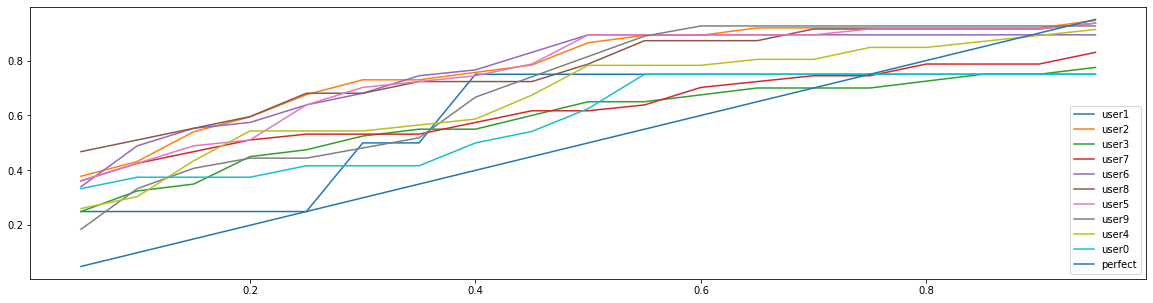

In [15]:
for user in df_metrics.index:
    df_metrics.loc[user].plot(legend=True, figsize=(20,5))

In [16]:
df_metrics["avg_abs_error"] = np.mean(np.abs(df_metrics[buckets] - buckets),axis=1)
df_metrics["bias"] = np.mean(df_metrics[buckets] - buckets,axis=1)
df_metrics.T.style.background_gradient(cmap='viridis', axis=1)

,user1,user2,user3,user7,user6,user8,user5,user9,user4,user0,perfect
0.05,0.250,0.378,0.250,0.362,0.340,0.468,0.362,0.185,0.261,0.333,0.050
0.1,0.250,0.432,0.325,0.426,0.489,0.511,0.426,0.333,0.304,0.375,0.100
0.15,0.250,0.541,0.350,0.468,0.553,0.553,0.489,0.407,0.435,0.375,0.150
0.2,0.250,0.595,0.450,0.511,0.574,0.596,0.511,0.444,0.543,0.375,0.200
0.25,0.250,0.676,0.475,0.532,0.638,0.681,0.638,0.444,0.543,0.417,0.250
0.3,0.500,0.730,0.525,0.532,0.681,0.681,0.702,0.481,0.543,0.417,0.300
0.35,0.500,0.730,0.550,0.532,0.745,0.723,0.723,0.519,0.565,0.417,0.350
0.4,0.750,0.757,0.550,0.574,0.766,0.723,0.745,0.667,0.587,0.500,0.400
0.45,0.750,0.784,0.600,0.617,0.830,0.723,0.787,0.741,0.674,0.542,0.450
0.5,0.750,0.865,0.650,0.617,0.894,0.787,0.894,0.815,0.783,0.625,0.500
